# PINN solver for Mandel's poroelasticity problem using sequential stress-split training 

Check out our paper for more details: 
**Physics-informed neural network simulation of multiphase poroelasticity using stress-split sequential training**

Find the paper at: [https://arxiv.org/abs/2110.03049](https://arxiv.org/abs/2110.03049)

Try it out on Google Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciann/sciann-applications/blob/master/SciANN-PoroElasticity/PINN-PoroElasticity-Mandel.ipynb)


Cite our work:
```
@article{haghighat2021physics,
  title={Physics-informed neural network simulation of multiphase poroelasticity using stress-split sequential training},
  author={Haghighat, Ehsan and Amini, Danial and Juanes, Ruben},
  journal={arXiv preprint arXiv:2110.03049},
  year={2021}
}
```

In [1]:
!pip install sciann==0.6.5.1 -q 

     |████████████████████████████████| 173 kB 15.6 MB/s 
     |████████████████████████████████| 561 kB 39.3 MB/s 
     |████████████████████████████████| 460.3 MB 7.5 kB/s 
     |████████████████████████████████| 462 kB 63.2 MB/s 
     |████████████████████████████████| 4.0 MB 47.1 MB/s 
     |████████████████████████████████| 14.8 MB 38.4 MB/s 
     |████████████████████████████████| 1.2 MB 33.2 MB/s 
     |████████████████████████████████| 132 kB 56.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as np 
import sciann as sn 
from sciann.utils.math import sign, abs, sigmoid, tanh, diff
import os, time 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

---------------------- SCIANN 0.6.5.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0] 



In [3]:
#@title Data generator block  
class DataGeneratorXYT:
  """ Generates 2D time-dependent collocation grid for training PINNs
  Taken from here: https://github.com/sciann/sciann-applications/tree/master/SciANN-DataGenerator 
  # Arguments:
    X: [X0, X1]
    Y: [Y0, Y1]
    T: [T0, T1]
    targets: list and type of targets you wish to impose on PINNs. 
        ('domain', 'ic', 'bc-left', 'bc-right', 'bc-bot', 'bc-top', 'all')
    num_sample: total number of collocation points. 
    logT: generate random samples logarithmic in time. 
  # Examples: 
    >> dg = DataGeneratorXYT([0., 1.], [0., 1.], [0., 1.], 
                             ["domain", "ic", "bc-left", "bc-right", "bc-bot", "bc-top"], 
                             10000)
    >> input_data, target_data = dg.get_data()
  """
  def __init__(self, 
               X=[0., 1.],
               Y=[0., 1.],
               T=[0., 1.],
               targets=['domain', 'ic', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'], 
               num_sample=10000,
               logT=False):
    'Initialization'
    self.Xdomain = X
    self.Ydomain = Y
    self.Tdomain = T
    self.logT = logT
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_uniform_T_samples(self, num_sample):
    if self.logT is True:
      t_dom = np.random.uniform(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), num_sample)
      t_dom = np.exp(t_dom) - 1.
    else:
      t_dom = np.random.uniform(self.Tdomain[0], self.Tdomain[1], num_sample)
    return t_dom

  def generate_data(self):
    # Half of the samples inside the domain.
    num_sample = int(self.num_sample/2)
    
    counter = 0
    # domain points 
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    y_dom = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample)
    t_dom = self.generate_uniform_T_samples(num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # The other half distributed equally between BC and IC.
    num_sample = int(self.num_sample/4)

    # initial conditions
    x_ic = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    y_ic = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample)
    t_ic = np.full(num_sample, self.Tdomain[0])
    ids_ic = np.arange(x_ic.shape[0]) + counter 
    counter += ids_ic.size

    # bc points 
    num_sample_per_edge = int(num_sample/4)
    # left bc points 
    x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
    y_bc_left = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
    t_bc_left = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points 
    x_bc_right = np.full(num_sample_per_edge, self.Xdomain[1])
    y_bc_right = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
    t_bc_right = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter 
    counter += ids_bc_right.size

    # bot bc points 
    x_bc_bot = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample_per_edge)
    y_bc_bot = np.full(num_sample_per_edge, self.Ydomain[0])
    t_bc_bot = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_bot = np.arange(x_bc_bot.shape[0]) + counter
    counter += ids_bc_bot.size

    # right bc points 
    x_bc_top = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample-num_sample_per_edge)
    y_bc_top = np.full(num_sample-num_sample_per_edge, self.Ydomain[1])
    t_bc_top = self.generate_uniform_T_samples(num_sample-num_sample_per_edge)
    ids_bc_top = np.arange(x_bc_top.shape[0]) + counter
    counter += ids_bc_top.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right, ids_bc_bot, ids_bc_top])
    ids_all = np.concatenate([ids_dom, ids_ic, ids_bc])

    ids = {
        'domain': ids_dom, 
        'bc-left': ids_bc_left, 
        'bc-right': ids_bc_right,
        'bc-bot': ids_bc_bot,
        'bc-top': ids_bc_top,
        'ic': ids_ic,
        'bc': ids_bc, 
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_grid = [
        np.concatenate([x_dom, x_ic, x_bc_left, x_bc_right, x_bc_bot, x_bc_top]).reshape(-1,1),
        np.concatenate([y_dom, y_ic, y_bc_left, y_bc_right, y_bc_bot, y_bc_top]).reshape(-1,1),
        np.concatenate([t_dom, t_ic, t_bc_left, t_bc_right, t_bc_bot, t_bc_top]).reshape(-1,1),
    ]
    total_sample = input_grid[0].shape[0]

    target_grid = []
    for i, tp in enumerate(self.targets):
      target_grid.append(
          (ids[tp], 'zeros')
      )
      
    return input_grid, target_grid

  def get_test_grid(self, Nx=50, Ny=50, Nt=100):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    ys = np.linspace(self.Ydomain[0], self.Ydomain[1], Ny)
    if self.logT:
      ts = np.linspace(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), Nt)
      ts = np.exp(ts) - 1.0
    else:
      ts = np.linspace(self.Tdomain[0], self.Tdomain[1], Nt)
    return np.meshgrid(xs, ys, ts)

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      y_data = self.input_data[1][ids,:]
      t_data = self.input_data[2][ids,:]
      fig = plt.figure()
      ax = fig.add_subplot(projection='3d')
      ax.scatter(x_data, y_data, t_data)
      ax.set_xlabel('x')
      ax.set_ylabel('y')
      ax.set_zlabel('t')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      ax = fig.add_subplot(projection='3d')
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        y_data = self.input_data[1][t_idx,:]
        t_data = self.input_data[2][t_idx,:]
        ax.scatter(x_data, y_data, t_data, label=t, c=next(cycol))
      ax.set_xlabel('x')
      ax.set_ylabel('y')
      ax.set_zlabel('t')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()

In [4]:
# Unit conversions 
s, minute, hr, day = 1., 60., 60.**2, 24*60.**2
g, kg = 1.e-3, 1.
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9
micro, milli, centi, kilo, mega = 1e-6, 1e-3, 1e-2, 1e3, 1e6
poise = 0.1*Pa*s
Darcy = 9.869233e-13*m**2

In [5]:
#----------parameters-----------
DTYPE = 'float32'

S_overburden = -2*MPa   
rho_b = 2400.0 * kg/m**3
rho_f = 1000. * kg/m**3
mu = 6. * milli * poise
k = 1e-12 
E = 120e6    
nu = 0.25
b = 1.0
M = 120e6    
Lx = 50*m
Ly = 10*m

Kdr = E/(3*(1-2*nu))
B = (b*M)/(Kdr+M*(b**2))
nu_u = (3*nu+b*B*(1-2*nu))/(3-b*B*(1-2*nu))
F = S_overburden*Ly*1*m 
Gshr = E/2/(1+nu)
Gama = B*(1+nu_u)/(3*(1-nu_u))
p0 = (-F)*B*(1+nu_u)/(3*Ly)

p_star = p0
x_star = Ly
t_star = (b**2/Kdr + 1/M)*mu*(x_star**2)/(k) #
nu_star = (1 - 2*nu)/(1 + nu) 
u_star = p_star*x_star/Kdr
D_star = b*M/((b**2)*M + Kdr)       
print("D_star = "+str(D_star)+",\np0 = "+str(p0/MPa)+" (MPa)")

D_star = 0.6,
p0 = 0.5555555555555555 (MPa)


In [6]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(124)

xd = sn.Variable('xd', dtype=DTYPE)
yd = sn.Variable('yd', dtype=DTYPE)
td = sn.Variable('td', dtype=DTYPE)

# increase network size for more accuracy: e.g. 8*[100]
pd = sn.Functional('pd', [xd, yd, td], 4*[20], 'tanh')
ud = sn.Functional('ud', [xd, yd, td], 4*[20], 'tanh')
vd = sn.Functional('vd', [xd, yd, td], 4*[20], 'tanh')
Evd = sn.Functional('Evd', [xd, yd, td], 4*[20], 'tanh')

x = xd*x_star
y = yd*x_star
p = pd*p_star
t = td*t_star
u = ud*u_star    
v = vd*u_star  

td_0 = 0.0 
td_f = 1000/t_star   
xd_min = 0.0 
xd_max = (Lx/x_star) 
yd_min = 0.0 
yd_max = (Ly/x_star) 

In [7]:
# ----------------------- Solid Mechanics -----------------------
ud_xd, ud_yd = diff(ud, xd), diff(ud, yd)
vd_xd, vd_yd = diff(vd, xd), diff(vd, yd)

Exxd = ud_xd
Eyyd = vd_yd
Exyd = (ud_yd + vd_xd)*0.5

Sxxd = (1-nu_star)*Evd + 3*nu_star*Exxd - b*(pd) 
Syyd = (1-nu_star)*Evd + 3*nu_star*Eyyd - b*(pd) 
Sxyd = 3*nu_star*Exyd   
Svd = Evd - b*(pd) 
Svd_td = diff(Svd, td)


Msx = sn.rename(diff(Evd, xd)  + 1.5*nu_star*(diff(ud_xd, xd) + diff(ud_yd, yd)) +\
                (nu_star/2)*diff(ud_xd+vd_yd, xd)  - b*diff(pd, xd), "Msx")
Msy = sn.rename(diff(Evd, yd)  + 1.5*nu_star*(diff(vd_xd, xd) + diff(vd_yd, yd)) +\
                (nu_star/2)*diff(ud_xd+vd_yd, yd)  - b*diff(pd, yd), "Msy")
MEv = sn.rename(ud_xd + vd_yd - Evd, "MEv")


C_Sxx_ini = sn.rename((td == td_0)*abs(Sxxd - S_overburden/p_star), "C_Sxx_ini")
C_Syy_ini = sn.rename((td == td_0)*abs(Syyd), "C_Syy_ini")

C_u_bc_left = sn.rename((xd == xd_min)*abs(Sxxd - S_overburden/p_star), "C_u_bc_left")
C_u_bc_right = sn.rename((xd == xd_max)*abs(ud), "C_u_bc_right")
C_u_bc_bot = sn.rename((yd == yd_min)*abs(Sxyd), "C_u_bc_bot")
C_u_bc_top = sn.rename((yd == yd_max)*abs(Sxyd), "C_u_bc_top")

C_v_bc_left = sn.rename((xd == xd_min)*abs(Sxyd), "C_v_bc_left")
C_v_bc_right = sn.rename((xd == xd_max)*abs(Sxyd), "C_v_bc_right")
C_v_bc_bot = sn.rename((yd == yd_min)*abs(vd), "C_v_bc_bot") 
C_v_bc_top = sn.rename((yd == yd_max)*abs(Syyd), "C_v_bc_top")

targets_solid = [sn.PDE(Msx), sn.PDE(Msy), sn.PDE(MEv),
                 C_Sxx_ini, C_Syy_ini, 
                 C_u_bc_left, C_u_bc_right, C_u_bc_bot, C_u_bc_top, 
                 C_v_bc_left, C_v_bc_right, C_v_bc_bot, C_v_bc_top]

In [8]:
# ----------------------- Fluid Mechanics -----------------------
Svd_td_seq = sn.Variable('Svd_td_seq', dtype=DTYPE)
pd_xd, pd_yd, pd_td = diff(pd,xd), diff(pd,yd), diff(pd,td)
 
Mp = sn.rename(pd_td - diff(pd_xd, xd) - diff(pd_yd, yd) + D_star*Svd_td_seq, "Mp")

C_p_ini = sn.rename((td == td_0)*abs(pd-1), "C_p_ini")
C_p_bc_top = sn.rename((yd == yd_max)*abs(pd), "C_p_bc_top")
C_q_bc_bot = sn.rename((yd == yd_min)*abs(pd_yd), "C_q_bc_bot")
C_q_bc_left = sn.rename((xd == xd_min)*abs(pd_xd) , "C_q_bc_left")
C_q_bc_right = sn.rename((xd == xd_max)*abs(pd_xd), "C_q_bc_right")

targets_fluid = [sn.PDE(Mp), C_p_ini, C_p_bc_top, C_q_bc_bot, C_q_bc_left, C_q_bc_right]   

In [9]:
# ----------------------- prediction model -----------------------
model_pred = sn.SciModel([xd,yd,td], [pd, ud, vd])

#-----definition of models for sequential process-------
solid = sn.SciModel([xd,yd,td], targets_solid)
fluid = sn.SciModel([xd,yd,td,Svd_td_seq], targets_fluid)

#----training parameters-------
NUM_SAMPLES = 100000
BATCH_SIZE = 1000   # higher batch size results in more accuracy
EPOCHS_FLUID = 100   # make sure (NUM_SAMPLES/BATCH_SIZE)*EPOCHS > 50K (total gradient updates)
EPOCHS_SOLID = 100
STOP_AFTER = None

# 
ADAPTIVE_WEIGHTS = {'method': 'GN', 'freq':300, 'use_score':True, 'alpha':1.0}    

initial_lr = 1e-3
final_lr = initial_lr/100

learning_rate_fluid = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": EPOCHS_FLUID
}
learning_rate_solid = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": EPOCHS_SOLID
}


dg_fluid = DataGeneratorXYT(
    X=[xd_min,xd_max], Y=[yd_min, yd_max], T=[td_0,td_f], 
    num_sample=NUM_SAMPLES,
    targets=['domain', 'ic', 'bc-top', 'bc-bot', 'bc-left', 'bc-right']
)
input_data_fluid, target_data_fluid = dg_fluid.get_data()


dg_solid = DataGeneratorXYT(
    X=[xd_min,xd_max], Y=[yd_min, yd_max], T=[td_0,td_f], 
    num_sample=NUM_SAMPLES,
    targets=['domain', 'domain', 'domain', 'ic', 'ic',
             'bc-left', 'bc-right', 'bc-bot', 'bc-top', 
             'bc-left', 'bc-right', 'bc-bot', 'bc-top']
)
input_data_solid, target_data_solid = dg_solid.get_data()


In [10]:
#@title custom plot functions 

def cust_semilogx(AX, X, Y, xlabel, ylabel, title, line_label=None):
    if X is None:
        im = AX.semilogy(Y, label=line_label)
    else:
        im = AX.semilogy(X, Y, label=line_label)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)
    if title  is not None: AX.set_title(title)  

def cust_plotx(AX, X, Y, xlabel, ylabel, title, line_label=None):
    if X is None:
        im = AX.plot(Y, label=line_label)
    else:
        im = AX.plot(X, Y, label=line_label)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)
    if title  is not None: AX.set_title(title)  

In [11]:
#@title Postprocessing data 
#-----------grid for evaluation of the trained model-------------

log10p = lambda x: np.log10(1. + x)
Nx, Ny, Nt = 11, 100, 200
xs = np.linspace(xd_min, xd_max, Nx)  
xs_u = np.linspace(xd_min, xd_max, Nx*10)  
ys = np.linspace(yd_min, yd_max, Ny*3)

ts = (np.logspace(0.1, log10p(td_f*t_star), Nt*3)-1.0)/t_star
Xdtest, Ydtest, Tdtest = np.meshgrid(xs, ys, ts, indexing='ij')

Xdtest_u_plot, Ydtest_u_plot, Tdtest_u_plot = np.meshgrid(xs_u, ys, ts, indexing='ij')

input_test = [Xdtest[10,:,:], Ydtest[10,:,:], Tdtest[10,:,:]] 
y_plot = input_test[1]*x_star
t_plot = np.log10(input_test[2]*t_star)

input_test_u = [Xdtest_u_plot[:,5,:], Ydtest_u_plot[:,5,:], Tdtest_u_plot[:,5,:]] 
xx_plot = input_test_u[0]*x_star
tt_plot = np.log10(input_test_u[2]*t_star)


Xtest = Xdtest*x_star
Ytest = Ydtest*x_star
Ttest = Tdtest*t_star


xs_p_line = np.linspace(xd_min, xd_max, Nx)  
xs_p_line = xs[-1:]
ys_p_line = np.linspace(yd_min, yd_max, Ny)
ts_p_line = [td_f*0.01, td_f*0.025, td_f*0.05,td_f*0.1, td_f*0.25, td_f*0.5, td_f*0.75, td_f*1.0]   # 
input_test_p_line = np.meshgrid(xs_p_line, ys_p_line, ts_p_line, indexing='ij')

xs_u_line = np.linspace(xd_min, xd_max, Nx*10)  
ys_u_line = np.linspace(yd_min, yd_max, Ny)
ys_u_line = ys[50]
ts_u_line = [td_f*0.01, td_f*0.025, td_f*0.05,td_f*0.1, td_f*0.25, td_f*0.5, td_f*0.75, td_f*1.0]   # 
input_test_u_line = np.meshgrid(xs_u_line, ys_u_line, ts_u_line, indexing='ij')


fname = 'Mandel_'

#-------plot settings------
legend_settings = {
    'bbox_to_anchor': (1.0, 1.0),
    'loc': 'upper left',
    'fontsize': 'medium',
    'fancybox': True,
    'frameon': False}

line_color = ['red','orange', 'blue', 'green', 'purple','cyan','gold', 'black']
line_style_true = ['r--','b--','y--','g--','c--']
line_style = ['r-.','b-.','y-.','g-.','c-.']

In [12]:
#@title Expected analytical solution 
#----------------exact solutions-----------------

def func(z):
    return np.tan(z) - ((1-nu)/(nu_u-nu))*z

a = np.around((np.linspace(1, 100, 100)*2-1)*(np.pi/2)*0.999999834, decimals=6)
roots = np.zeros_like(a)
residual = np.zeros_like(a)
for i in range(100):
    roots[i] = fsolve(func, a[i])
    residual[i] = np.tan(roots[i]) - ((1-nu)/(nu_u-nu))*roots[i]


##---------for pressure------

###------contour plot-----
p_true = np.zeros_like(input_test[1])
for i in range(100):
    alpha = roots[i]
    T1 = np.sin(alpha)/(alpha-np.sin(alpha)*np.cos(alpha))
    T2 = np.cos(alpha * (input_test[1])) - np.cos(alpha)
    T3 = np.exp(-(alpha**2) * input_test[2])
    p_true += T1 * T2 * T3
    
term1=2*(-F)*B*(1+nu_u)/(3*Ly)    
p_true = term1*p_true 
###------line plot------
p_true_line = np.zeros_like(input_test_p_line[1])

for i in range(100):
    alpha = roots[i]
    T1 = np.sin(alpha)/(alpha-np.sin(alpha)*np.cos(alpha))
    T2 = np.cos(alpha * (input_test_p_line[1])) - np.cos(alpha)
    T3 = np.exp(-(alpha**2) * input_test_p_line[2])
    p_true_line += T1 * T2 * T3
    
term1=2*(-F)*B*(1+nu_u)/(3*Ly)    
p_true_line = term1*p_true_line/MPa   


##-------for vertical displacement-----

###------contour plot-----
v_true_part1 = np.zeros_like(input_test[2])
v_true_part2 = np.zeros_like(input_test[2])
term1 = F*nu/(2*Gshr*Ly)
term2 = F*nu_u/(Gshr*Ly)
term3 = F/Gshr
for i in range(100):
    alpha = roots[i]
    T1 = (np.sin(alpha)*np.cos(alpha))/(alpha - np.sin(alpha)*np.cos(alpha))
    T2 = np.exp(-(alpha**2) * input_test[2])
    T3 = (np.cos(alpha))/(alpha - np.sin(alpha)*np.cos(alpha))
    T4 = np.sin(alpha * (input_test[1]))
    v_true_part1 += T1*T2
    v_true_part2 += T3*T4*T2

v_true = (np.ones_like(input_test[2])*term1 - term2*v_true_part1)*input_test[1]*Ly + term3*v_true_part2  
###-----line plot------
v_true_part1 = np.zeros_like(input_test_p_line[2])
v_true_part2 = np.zeros_like(input_test_p_line[2])
term1 = F*nu/(2*Gshr*Ly)
term2 = F*nu_u/(Gshr*Ly)
term3 = F/Gshr
for i in range(np.size(a)):
    alpha = roots[i]
    T1 = (np.sin(alpha)*np.cos(alpha))/(alpha - np.sin(alpha)*np.cos(alpha))
    T2 = np.exp(-(alpha**2) * input_test_p_line[2])
    T3 = (np.cos(alpha))/(alpha - np.sin(alpha)*np.cos(alpha))
    T4 = np.sin(alpha * (input_test_p_line[1]))
    v_true_part1 += T1*T2
    v_true_part2 += T3*T4*T2

v_true_line = (np.ones_like(input_test_p_line[2])*term1 - term2*v_true_part1)*input_test_p_line[1]*Ly + term3*v_true_part2 

##---------for horizontal displacement-----

###------contour plot------
u_true = np.zeros_like(input_test_u[2])
term1 = -F*(1-nu)/(2*Gshr*Ly)
term2 = F*(1-nu_u)/(Gshr*Ly)
for i in range(100):
    alpha = roots[i]
    T1 = (np.sin(alpha)*np.cos(alpha))/(alpha - np.sin(alpha)*np.cos(alpha))
    T2 = np.exp(-(alpha**2) * input_test_u[2])
    u_true += T1*T2
    
u_true = (term1 + term2*u_true)*(Lx - input_test_u[0]*x_star)  
###------line plot-------
u_true_line = np.zeros_like(input_test_u_line[2])
term1 = -F*(1-nu)/(2*Gshr*Ly)
term2 = F*(1-nu_u)/(Gshr*Ly)
for i in range(np.size(a)):
    alpha = roots[i]
    T1 = (np.sin(alpha)*np.cos(alpha))/(alpha - np.sin(alpha)*np.cos(alpha))
    T2 = np.exp(-(alpha**2) * input_test_u_line[2])
    u_true_line += T1*T2
    
u_true_line = (term1 + term2*u_true_line)*(Lx - input_test_u_line[0]*x_star)  

In [13]:
#@title Post processing (plotting) functions  
def plot_loss_history(H_fluid, H_solid, itr):
    fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    for key, val in H_fluid.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[0,0], None, np.array(val)/val[0], None, "Fluid", "L/L0", key)
    ax[0,0].legend(loc="upper right")
    cust_semilogx(ax[0,1], None, np.array(H_fluid.history["lr"]), None,None, "lr")
    cust_semilogx(ax[0,2], None, np.array(H_fluid.history["time"]), None, None, "time")
    
    for key, val in H_solid.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[1,0], None, np.array(val)/val[0], None, "Solid", None, key)
    ax[1,0].legend(loc="upper right")
    cust_semilogx(ax[1,1], None, np.array(H_solid.history["lr"]), None, None, None)
    cust_semilogx(ax[1,2], None, np.array(H_solid.history["time"]), None, None, None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig(fname+'_history_itr{:02d}.jpg'.format(itr+1), dpi=300) 
    plt.show()
    plt.close()


def plot_pressure_lineplots(pred_itr, itr):
    fig, ax = plt.subplots(3,3, figsize=(12,10))

    for i in range(np.size(ts_p_line)):
        time_plot=np.around(ts_p_line[i]*t_star,decimals=1)
        ax[0,0].plot(ys_p_line*x_star, pred_itr['p_true_line'][0,:,i], color=line_color[i],linestyle='-')
        ax[0,1].plot(ys_p_line*x_star, pred_itr['p_line'][0,:,i], color=line_color[i],linestyle='--')
        ax[0,2].plot(ys_p_line*x_star, np.abs(pred_itr['p_line'][0,:,i]-pred_itr['p_true_line'][0,:,i]), 
                   color=line_color[i],linestyle='-.', label='t = '+str(time_plot))
        ax[1,0].plot(ys_p_line*x_star, pred_itr['v_true_line'][0,:,i], color=line_color[i],linestyle='-')
        ax[1,1].plot(ys_p_line*x_star, pred_itr['v_line'][0,:,i], color=line_color[i],linestyle='--')
        ax[1,2].plot(ys_p_line*x_star, np.abs(pred_itr['v_line'][0,:,i]-pred_itr['v_true_line'][0,:,i]), 
                   color=line_color[i],linestyle='-.', label='t = '+str(time_plot))
        ax[2,0].plot(xs_u_line*x_star, pred_itr['u_true_line'][:,0,i], color=line_color[i],linestyle='-')
        ax[2,1].plot(xs_u_line*x_star, pred_itr['u_line'][:,0,i], color=line_color[i],linestyle='--')
        ax[2,2].plot(xs_u_line*x_star, np.abs(pred_itr['u_line'][:,0,i]-pred_itr['u_true_line'][:,0,i]), 
                   color=line_color[i],linestyle='-.', label='t = '+str(time_plot))
        
    ax[0,0].hlines(y=p0/MPa, xmin=0, xmax=yd_max*x_star, color='black', linestyle=':')
    ax[0,1].hlines(y=p0/MPa, xmin=0, xmax=yd_max*x_star, color='black', linestyle=':')
    
    ax[0,0].set_xlabel('y (m)'),ax[0,0].set_ylabel('$p~(MPa)$')
    ax[0,1].set_xlabel('y (m)'),ax[0,1].set_ylabel('$p^*~(MPa)$')
    ax[0,2].set_xlabel('y (m)'),ax[0,2].set_ylabel('$|p-p^*|~(MPa)$')
    ax[0,0].set_ylim(0,0.6),ax[0,1].set_ylim(0,0.6)
    ax[0,0].grid(True),ax[0,1].grid(True),ax[0,2].grid(True)      
    
    ax[1,0].set_xlabel('y (m)'),ax[1,0].set_ylabel('$v~(m)$')
    ax[1,1].set_xlabel('y (m)'),ax[1,1].set_ylabel('$v^*~(m)$')
    ax[1,2].set_xlabel('y (m)'),ax[1,2].set_ylabel('$|v-v^*|~(m)$')
    ax[1,0].set_ylim(0,0.08),ax[1,1].set_ylim(0,0.08),ax[1,2].set_ylim(0,0.008)
    ax[1,2].legend(**legend_settings)
    ax[1,0].grid(True),ax[1,1].grid(True),ax[1,2].grid(True)
    
    ax[2,0].set_xlabel('x (m)'),ax[2,0].set_ylabel('$u~(m)$')
    ax[2,1].set_xlabel('x (m)'),ax[2,1].set_ylabel('$u^*~(m)$')
    ax[2,2].set_xlabel('x (m)'),ax[2,2].set_ylabel('$|u-u^*|~(m)$')
    ax[2,0].set_ylim(0,0.8),ax[2,1].set_ylim(0,0.8),ax[2,2].set_ylim(0,0.08)
    ax[2,0].grid(True),ax[2,1].grid(True),ax[2,2].grid(True)
    plt.subplots_adjust(0.1, 0.1, 0.9, 0.9, wspace=0.35, hspace=0.3)
    plt.savefig(fname+'_LinePlot_itr{:02d}.jpg'.format(itr+1), dpi=300)  
    plt.show()
    plt.close()



def plot_pressure_contourplots(pred_itr, itr):
    fig, ax = plt.subplots(3,3,figsize=(12, 10))
    plt.colorbar(ax[0,0].pcolor(t_plot, y_plot, pred_itr['p'], cmap='jet_r',vmin=0.0,vmax=0.6), ax=ax[0,0])
    plt.colorbar(ax[0,1].pcolor(t_plot, y_plot, pred_itr['p_true'], cmap='jet_r',vmin=0.0,vmax=0.6), ax=ax[0,1])
    plt.colorbar(ax[0,2].pcolor(t_plot, y_plot, np.abs(pred_itr['p'] - pred_itr['p_true']) 
                                , cmap='jet_r',vmin=0,vmax=0.06), ax=ax[0,2])
    ax[0,0].set_title('$p~(MPa)$'),ax[0,1].set_title('$p^*~(MPa)$'),ax[0,2].set_title('$|p-p^*|~(MPa)$')
    ax[0,0].set_ylabel('$Y~(m)$'), ax[0,1].set_yticks([]), ax[0,2].set_yticks([])
    
    plt.colorbar(ax[1,0].pcolor(t_plot,y_plot, pred_itr['v'], cmap='jet_r',vmin=0.0,vmax=0.08), ax=ax[1,0])
    plt.colorbar(ax[1,1].pcolor(t_plot,y_plot, pred_itr['v_true'], cmap='jet_r',vmin=0.0,vmax=0.08), ax=ax[1,1])
    plt.colorbar(ax[1,2].pcolor(t_plot,y_plot,np.abs(pred_itr['v'] - pred_itr['v_true'])
                                ,cmap='jet_r',vmin=0.0,vmax=0.008), ax=ax[1,2])
    ax[1,0].set_title('$v~(m)$'),ax[1,1].set_title('$v^*~(m)$'),ax[1,2].set_title('$|v-v^*|~(m)$')
    ax[1,0].set_ylabel('$Y~(m)$'), ax[1,1].set_yticks([]), ax[1,2].set_yticks([])

    
    plt.colorbar(ax[2,0].pcolor(tt_plot,xx_plot, pred_itr['u'], cmap='jet_r',vmin=0.0,vmax=0.8), ax=ax[2,0])
    plt.colorbar(ax[2,1].pcolor(tt_plot,xx_plot, pred_itr['u_true'], cmap='jet_r',vmin=0.0,vmax=0.8), ax=ax[2,1])
    plt.colorbar(ax[2,2].pcolor(tt_plot,xx_plot,np.abs(pred_itr['u'] - pred_itr['u_true'])
                                ,cmap='jet_r',vmin=0.0,vmax=0.08), ax=ax[2,2])
    ax[2,0].set_title('$u~(m)$'),ax[2,1].set_title('$u^*~(m)$'),ax[2,2].set_title('$|u-u^*|~(m)$')
    ax[2,0].set_ylabel('$x~(m)$'),ax[2,0].set_xlabel('$log10(t)~(s)$'), ax[2,1].set_xlabel('$log10(t)~(s)$'), ax[2,2].set_xlabel('$log10(t)~(s)$')
    ax[2,1].set_yticks([]), ax[2,2].set_yticks([])
    plt.subplots_adjust(0.1, 0.1, 0.9, 0.9, wspace=0.15, hspace=0.3)
    plt.savefig(fname+'_ContourPlot_itr{:02d}.jpg'.format(itr+1), dpi=300)
    plt.show()    
    plt.close()




In [ ]:
#--------sequential training algorithm------------

n_itr = 5

loss_fluid, loss_solid, lr_fluid, lr_solid, time_fluid, time_solid = [],[],[],[],[],[]

Sv_evaluation = np.zeros_like(input_data_fluid[0])

start_time = time.time()
for itr in range(n_itr):
    
    itr_time = time.time()
    if itr==0:
        kwrds = {'adaptive_weights': ADAPTIVE_WEIGHTS}
    else:
        kwrds = {}
    
    ud.set_trainable(False)
    vd.set_trainable(False)
    Evd.set_trainable(False)
    pd.set_trainable(True)
    fluid.compile()
    
    H_fluid = fluid.train(input_data_fluid + [Sv_evaluation], 
                          target_data_fluid,
                          learning_rate=learning_rate_fluid,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS_FLUID,
                          stop_loss_value=1e-8,
                          stop_after=STOP_AFTER,
                          verbose=0,
                          **kwrds)
    
    fluid.save_weights(fname+'_fluid_weights_itr{:02d}.hdf5'.format(itr+1))
    
    ud.set_trainable(True)
    vd.set_trainable(True)
    Evd.set_trainable(True)
    pd.set_trainable(False)
    solid.compile()

    H_solid = solid.train(input_data_solid, 
                          target_data_solid,
                          learning_rate=learning_rate_solid,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS_SOLID,
                          stop_loss_value=1e-8,
                          stop_after=STOP_AFTER,
                          verbose=0,
                          **kwrds)
    
    solid.save_weights(fname+'_solid_weights_itr{:02d}.hdf5'.format(itr+1))
    Sv_evaluation = Svd_td.eval(model_pred, input_data_fluid)

    loss_fluid += H_fluid.history["loss"]
    loss_solid += H_solid.history["loss"]
    lr_fluid += H_fluid.history["lr"]
    lr_solid += H_solid.history["lr"]
    time_fluid += H_fluid.history["time"]
    time_solid += H_solid.history["time"]
    
    print('\n -- iteration {} is completed in {}s, total in {}s... \n'.format(
          itr+1, time.time()-itr_time, time.time()-start_time))
    
    pred_itr = {
        'v': (vd.eval(model_pred, input_test))*u_star/m,
        'v_true': -v_true/m,
        'u': (ud.eval(model_pred, input_test_u))*u_star/m,
        'u_true': u_true/m,
        'p': (pd.eval(model_pred, input_test))*p_star/MPa,
        'p_true': p_true/MPa,
        'p_true_line': p_true_line,
        'p_line': (pd.eval(model_pred, input_test_p_line))*p_star/MPa,
        'v_true_line': -v_true_line/m,
        'v_line': (vd.eval(model_pred, input_test_p_line))*u_star/m,
        'u_true_line': u_true_line/m,
        'u_line':(ud.eval(model_pred, input_test_u_line))*u_star/m
    }    
    


Total samples: 112500 
Batch size: 1000 
Total batches: 113 


+ adaptive_weights at epoch 1: [0.9002790256045052, 0.9000690216043884, 0.9001908616914779, 0.9004380969415928, 0.9000921369076742, 1.4989308572503615]

Total samples: 112500 
Batch size: 1000 
Total batches: 113 


+ adaptive_weights at epoch 1: [0.9651458600934066, 0.9101217991389117, 0.9297763031266683, 0.9017671868186032, 0.9047133494466016, 0.9015319700229917, 0.908984928936406, 0.9534079296032915, 0.9894401734494924, 0.980217882856871, 1.6941741449063592, 0.9340194364656171, 1.0266990351347796]

 -- iteration 1 is completed in 515.5723142623901s, total in 515.5730738639832s... 


Total samples: 112500 
Batch size: 1000 
Total batches: 113 


+ adaptive_weights at epoch 1: [0.8109164983055059, 0.8101657444856705, 0.8111137666914364, 0.8118377412606984, 0.8101419661605327, 1.945824229451976]

Total samples: 112500 
Batch size: 1000 
Total batches: 113 


+ adaptive_weights at epoch 1: [0.9379675627471622, 0.83333269315

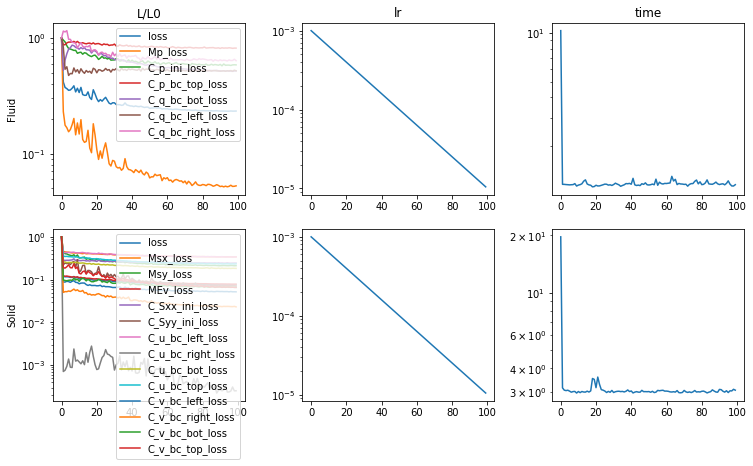

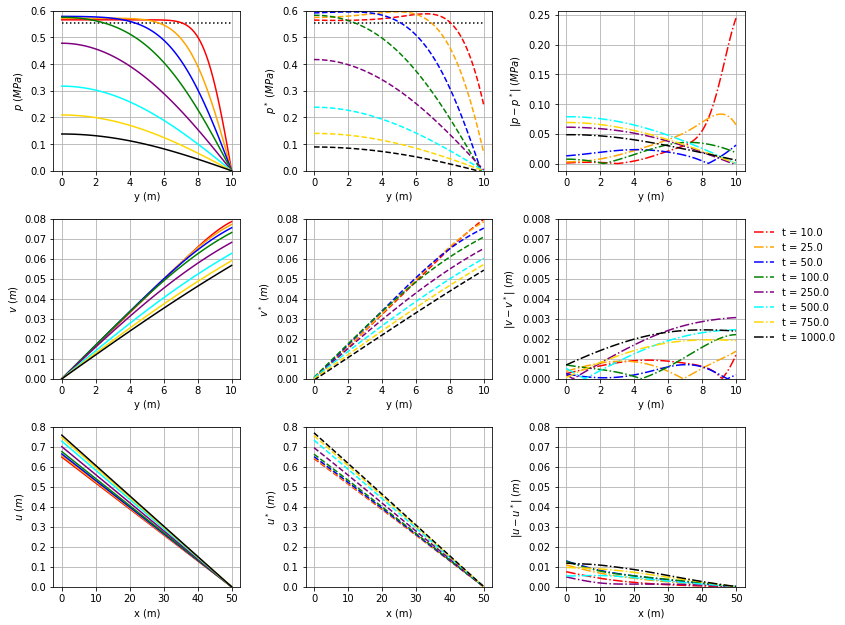

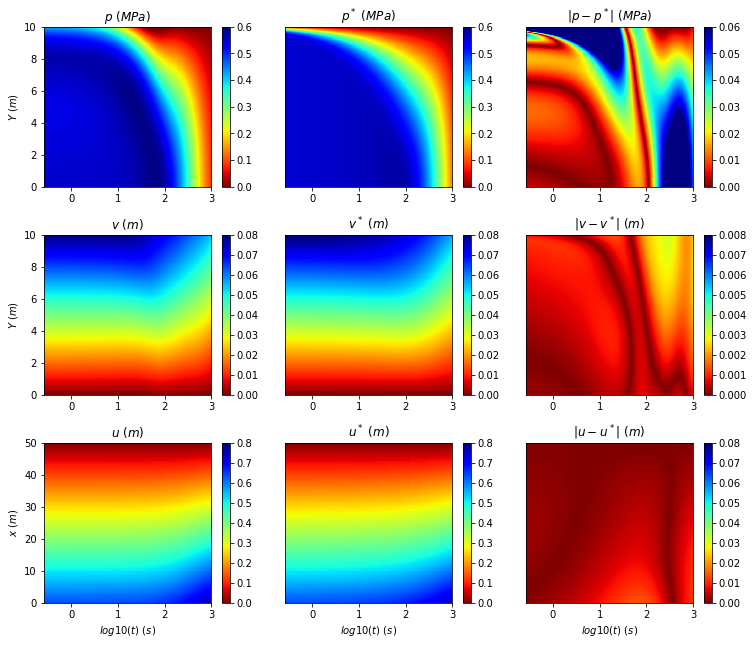

In [15]:

plot_loss_history(H_fluid, H_solid, itr) 

plot_pressure_lineplots(pred_itr, itr)

plot_pressure_contourplots(pred_itr, itr)

